# Factors influencing client choice

## Context
This analysis was done for a company which provides online and mobile platform that matches freelance labor with local demand.

## The problem
Determine the factors that impact a client choice to select a freelancer.

## Approach
Predictive model using supervised machine learning algorithm (Random Forest).

### Data
Sample data, simulating a real-world data set. The dataset contains information about "recommendations". A "recommendation" is the group of Taskers from which the Client can choose one to book. 

Column description:
* recommendation_id: unique identifier for this recommendation, or set of freelancers shown
* timestamp: when this recommendation was shown to the client
* tasker_id: unique identifier for the freelancer
* position: the position of the freelancer in the recommendation set, 1 - first, 2 - second, etc.
* hourly_rate: the hourly rate for the freelancer when they were shown
* num_completed_tasks: the number of tasks the freelancer had completed in that category, when they were shown
* hired: was the freelancer hired or not?  Only 1 tasker out of a set of recommendations can be hired
* category: the category of work the client needs help with

In [40]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# Randomized search on hyper parameters
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import resample

In [2]:
os.chdir('/Users/selenereyes/dir-python/data')

### Importing the data

In [3]:
df0 = pd.read_csv('data_analyst_sample_data.csv', 
                        parse_dates=['created_at'])
df0.head()

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1006892359,2,40,193,0,Furniture Assembly
2,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1012023956,3,28,0,0,Furniture Assembly
3,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1009733517,4,43,303,0,Furniture Assembly
4,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:00,1013579273,5,29,39,0,Furniture Assembly


# Exploratory Data Analysis

In [4]:
print(df0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
recommendation_id      30000 non-null object
created_at             30000 non-null datetime64[ns]
tasker_id              30000 non-null int64
position               30000 non-null int64
hourly_rate            30000 non-null int64
num_completed_tasks    30000 non-null int64
hired                  30000 non-null int64
category               30000 non-null object
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 1.8+ MB
None


The data ranges from 2017-09-01 to 2017-09-30

In [5]:
df0.created_at.apply(['min','max'])

min   2017-09-01 00:32:00
max   2017-09-30 23:15:00
Name: created_at, dtype: datetime64[ns]

### Number of recommendation sets in this data sample

In [9]:
df0.recommendation_id.nunique() 

2100

* There are 2,100 recommendation sets in this dataset.

### Trends over time
The chart below gives a an overview of the daily recommendation shown and bookings during the period analyzed.

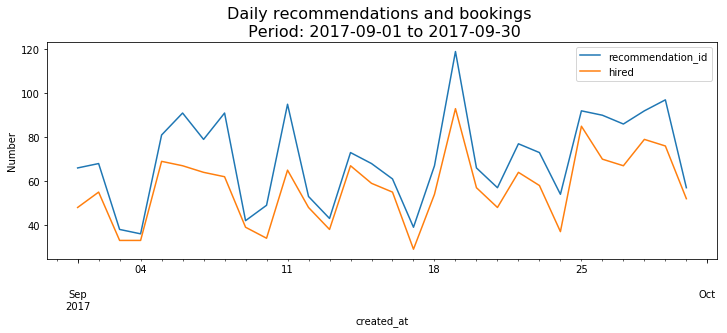

In [6]:
daily = df0.groupby(pd.Grouper(key='created_at',freq='D'))\
['recommendation_id','hired'].agg({'recommendation_id': pd.Series.nunique,
                                  'hired': 'sum'})                                  
#print(daily_recom.head())

daily.plot(figsize=(12,4))
plt.title('Daily recommendations and bookings \n Period: 2017-09-01 to 2017-09-30', 
          size=16)
plt.ylabel('Number');

The chart below gives shows the weekly count of recommendation and bookings during the period analyzed. It looks that after the first week, the number of recommendations and bookings stays constant. 

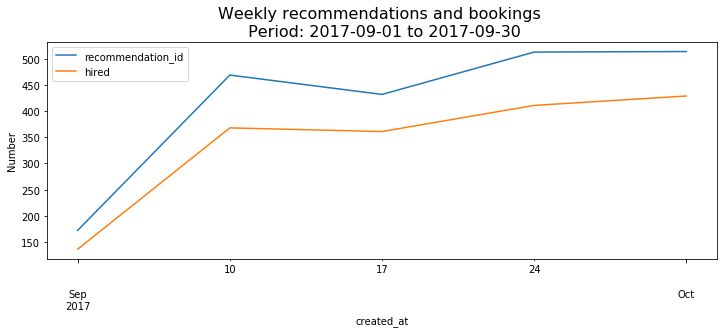

In [7]:
weekly = df0.groupby(pd.Grouper(key='created_at',freq='W'))\
['recommendation_id','hired'].agg({'recommendation_id': pd.Series.nunique,
                                  'hired': 'sum'})                                  
#print(daily_recom.head())

weekly.plot(figsize=(12,4))
plt.title('Weekly recommendations and bookings \n Period: 2017-09-01 to 2017-09-30', 
          size=16)
plt.ylabel('Number');

* Note that when aggregating over week, the time dependecy desapeared.

### Conversion rate per category
Considering the formula:
$$\text{Conversion_Rate}=\frac{\text{Freelancers_hired}}{\text{Total_recommendations_shown}}$$<br>

The conversion rate per category is calculated for the period analyzed.

In [8]:
recom_by_cat = df0.groupby('category').recommendation_id.nunique()
hires_by_cat = df0.groupby('category').hired.sum()
conv_rate_by_cat = hires_by_cat*100/recom_by_cat
print("\n * Recommendations by category: "+str(recom_by_cat) +
     "\n\n * Hires by category: " + str(hires_by_cat)+
     "\n\n * Conversion rate by category: " + str(round(conv_rate_by_cat,1)))


 * Recommendations by category: category
Furniture Assembly    702
Mounting              705
Moving Help           693
Name: recommendation_id, dtype: int64

 * Hires by category: category
Furniture Assembly    572
Mounting              562
Moving Help           571
Name: hired, dtype: int64

 * Conversion rate by category: category
Furniture Assembly    81.5
Mounting              79.7
Moving Help           82.4
dtype: float64


### Each recommendation set shows from 1 to 15 freelancers. Below are calculated: 
     - average number of freelancers shown
     - median  number of freelancers shown

In [10]:
taskers_per_rec = df0.groupby(['recommendation_id'])['tasker_id'].count()
# Average and median of number of taskers shown per recommendation 
taskers_per_rec.agg({'Mean': np.mean, 'Median': np.median}).round(1)

Mean      14.3
Median    15.0
Name: tasker_id, dtype: float64

* On average, each recommendation shows 14 freelancers.<br>
* The median number of freelancers shown per recommendation is 15.<br>

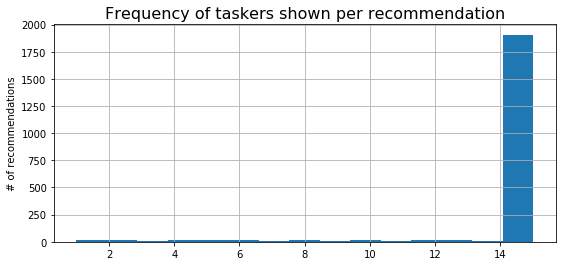

In [11]:
taskers_per_rec.hist(figsize=(9,4), bins=15);
plt.title('Frequency of taskers shown per recommendation', size=16)
plt.ylabel('# of recommendations');

* The chart below displays the distribution of number of freelancers shown. In this dataset, few recommendations showed less than 15 freelancers. Almost 2,000 users were shown 15 freelancers per recommendations during the analyzed period.

### Distribution of booking rate by position for each category
Booking rate: number of hires divided by number of tasker displayed

In [13]:
booking_rate = df0.groupby( ['category', 'position'] )['hired']\
                .mean().round(2)
booking_rate_df = pd.DataFrame({'booking_rate' : booking_rate}).reset_index()
booking_rate_df[['booking_rate','position','category']]

,booking_rate,position,category
0,0.33,1,Furniture Assembly
1,0.14,2,Furniture Assembly
2,0.01,3,Furniture Assembly
3,0.09,4,Furniture Assembly
4,0.04,5,Furniture Assembly
5,0.04,6,Furniture Assembly
6,0.04,7,Furniture Assembly
7,0.02,8,Furniture Assembly
8,0.03,9,Furniture Assembly
9,0.03,10,Furniture Assembly


The bar chart below shows the that for all three categories, taskers that are displayed in the first position have the highest booking rate.

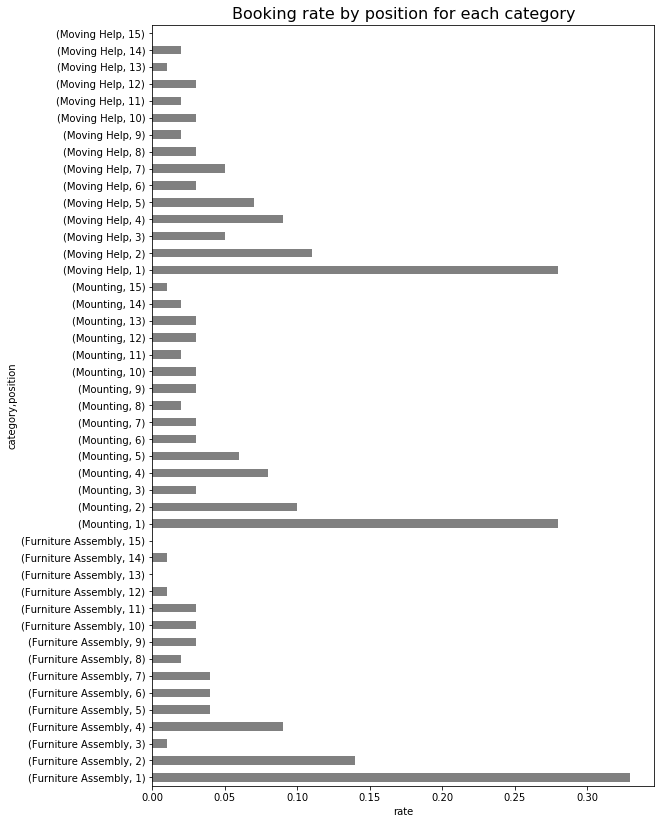

In [14]:
plt.figure(figsize=(9, 14))
booking_rate.plot('barh', color='grey')
plt.title('Booking rate by position for each category', size=16)
plt.xlabel('rate');

The below table presents the same information in a format that simplifies comarison across categories.

In [15]:
# Presenting the information in a format that allows to compare categories
booking_rate.unstack(level=1).T

category,Furniture Assembly,Mounting,Moving Help
position,,,
1,0.33,0.28,0.28
2,0.14,0.10,0.11
3,0.01,0.03,0.05
4,0.09,0.08,0.09
5,0.04,0.06,0.07
6,0.04,0.03,0.03
7,0.04,0.03,0.05
8,0.02,0.02,0.03
9,0.03,0.03,0.02


### For each category, average position of the freelancer who is hired

In [16]:
df0[df0['hired'] == 1].groupby(['category'])['position'].mean().round(1)

category
Furniture Assembly    3.6
Mounting              4.6
Moving Help           4.1
Name: position, dtype: float64

* On average, freelancers that are hired are displayed in the positions shown above.<br>
* It is worth mentioning that the median position for hired freelancers is lower than the average position, which indicates that the data is right skewed. See results below.

In [17]:
df0[df0['hired'] == 1].groupby(['category'])['position'].agg({'mean','median'}).round(1)

,mean,median
category,,
Furniture Assembly,3.6,2
Mounting,4.6,3
Moving Help,4.1,3


### For each category, average hourly rate and average number of completed tasks for the freelancers who are hired

In [18]:
df0[df0['hired'] ==1].groupby(['category']).agg({
                                          'hourly_rate':['mean', 'median'],
                                          'num_completed_tasks':['mean','median']
                                            }).round(2)

hourly_rate        num_completed_tasks       
                          mean median                mean median
category                                                        
Furniture Assembly       38.70     38              249.02  131.5
Mounting                 50.15     50              284.10  190.0
Moving Help              63.01     49              273.88  147.0

On average, hired freelancers in the:
* furniture assembly category charge 38.70 UDS per hour (the lowest rate of all three categories)
* mounting category charge 50.15 USD per hour
* moving help charge 63.01 USD per hour (the highest rate of all three categories). The median hourly rate is only 49 USD.

On average, freelancers hired have completed more than 250 tasks. However, the median value is significantly lower.

### For each category, average hourly rate and average number of completed tasks for the freelancers who are not hired

In [19]:
df0[df0['hired'] ==0].groupby(['category']).agg({
                                          'hourly_rate':['mean', 'median'],
                                          'num_completed_tasks':['mean','median']
                                            }).round(2)

hourly_rate        num_completed_tasks       
                          mean median                mean median
category                                                        
Furniture Assembly       39.46     38              182.00     74
Mounting                 50.49     50              216.47    118
Moving Help              83.74     65              256.62    144

* On average, freelancers that are not hired have similar hourly rate than hired ones, with the exception of moving help (this freelancers charge 83.74 USD per hour => ~ 21 USD per hour more, on average, than hired freelancers).

* Freelancers that are not higher have completed less tasks, on average, than the freelancers that are hired.

# What factors do impact a client choice to select a freelancer? 

This is a binary classification problem, where 'hired' is the target variable (1 when the freelancer is hired and 0 when not).<br>
The features used for the predictive model are position, hourly_rate, num_completed_tasks, and category. 

As seen at the beginning of this notebook, time dependency disappears when aggregating data over week, however, there will not be enough data points after averaging over week. Therefore, For simplicity, as a minimum viable product model, the timestamp is not considered as a feature in the machine learning modelling. <br>

### Building the new dataframe for the analysis

In [21]:
col = ['position', 'hourly_rate', 'num_completed_tasks', 'category', 'hired']
data = df0[col]

In [22]:
data.shape

(30000, 5)

Checking how many observation are in each class of the target variable 'hired'.

hired
0    28295
1     1705
Name: category, dtype: int64


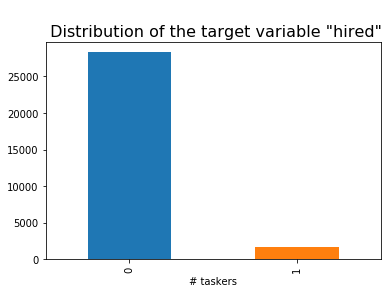

In [23]:
result_count = data.groupby('hired')['category'].count()
print(result_count)

plt.title('\n Distribution of the target variable "hired"', size=16)
result_count.plot(kind='bar')
plt.xlabel('# taskers');

* There are more than 28,000 observations of taskers that are not hired (0) and only 1,705 observations of hired taskers. Therefore the data are umbalance. This represents a problem for training the model, which will be addressed in more detail later.

### Distribution of variables 
The boxplots below shows the distribution of the explanatory variables.

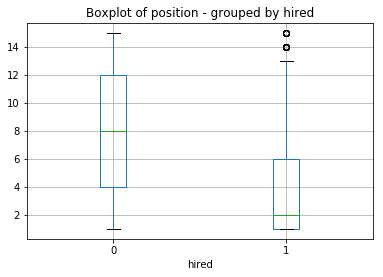

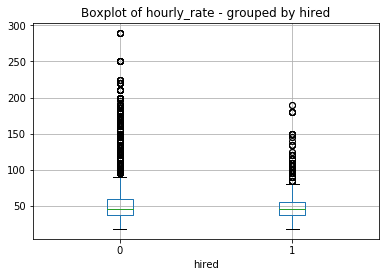

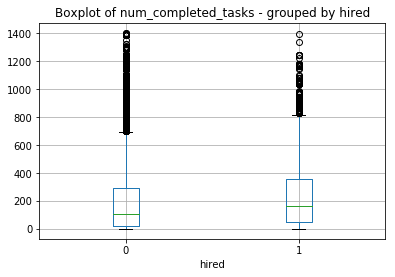

In [24]:
data.boxplot(column='position', by='hired')
plt.title("Boxplot of position - grouped by hired")
plt.suptitle("");

data.boxplot(column='hourly_rate', by='hired')
plt.title("Boxplot of hourly_rate - grouped by hired")
plt.suptitle("");

data.boxplot(column='num_completed_tasks', by='hired')
plt.title("Boxplot of num_completed_tasks - grouped by hired")
plt.suptitle("");

* For not hired taskers, the median position is 8, whereas the median position for hired taskers is 2. This feature is a potential important factor for the predictive model.

* On the otehr hand, there is not a clear difference in the hourly rate charged by hired and not hired taskers (as it was pointed out in question 6). 

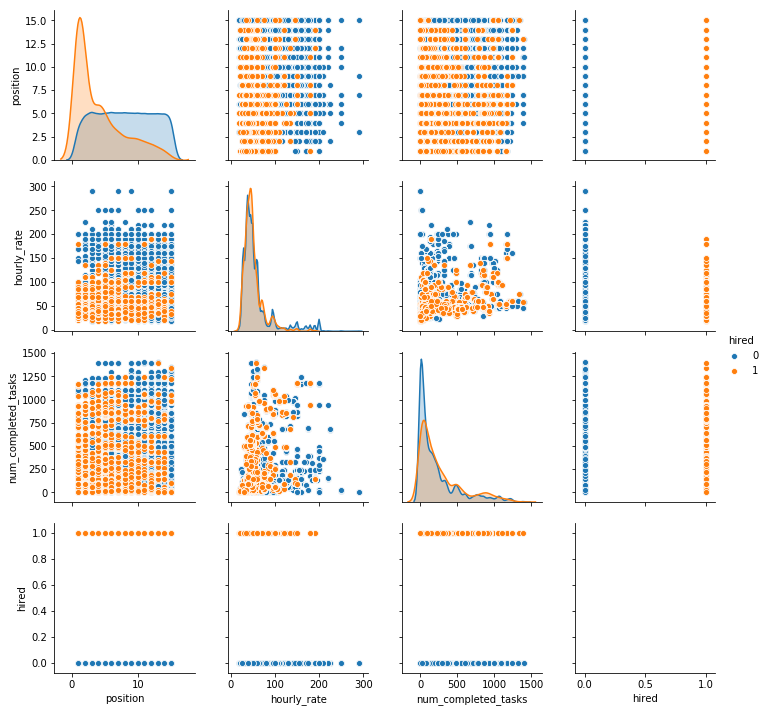

In [25]:
sns.pairplot(data, hue="hired");

* The plot above shows the relationship between variables (scatterplots) and the distribution of features. For both classes (hired and non hired) the distribution of _'hourly rate'_ and  _'number of completed tasks'_ are right skewed. This is the case for _'position'_ of taskers that are hired but the distribution of taskers that are not hired is very close to be uniform.

## Correlation Matrix

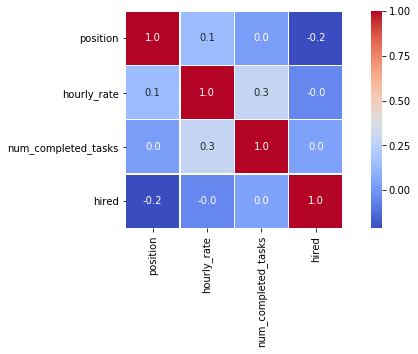

In [26]:
corr = data.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(10, 4))
sns.heatmap(corr, cbar = True,  square = True, annot = True, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax);

* The heatmap shows that the correlations between explanatory variables is very low. That is, each of them has a different effect on the target variable. Therefore, there are not multicollinearity issues.

## Building a predictive model

The dataset has a categorical feature, 'category', which needs to be codified in order to be understood by the algorithm. 

In [27]:
X = data.drop('hired', axis =1, inplace=False) # features
y = data.hired # target

X.head(2)

,position,hourly_rate,num_completed_tasks,category
0,1,38,151,Furniture Assembly
1,2,40,193,Furniture Assembly


Each category was converted to a number using LabelEncoder: 
* 0 ==> Furniture Assembly
* 1 ==> Moving Help
* 2 ==> Mounting 

In [28]:
labelencoder = LabelEncoder()
X.category = labelencoder.fit_transform(X.category)

X.head()

,position,hourly_rate,num_completed_tasks,category
0,1,38,151,0
1,2,40,193,0
2,3,28,0,0
3,4,43,303,0
4,5,29,39,0


But now the categories have an ordered relationship which is not true in reality. OnehotEncoder converts those features to vectors, as shown below.

In [39]:
# Separating the labels
ohe = OneHotEncoder(categorical_features = [3])
X_onehot = ohe.fit_transform(X).toarray()

X_onehot.shape # array

/Users/selenereyes/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


(30000, 6)

The result is an array that was converted into a dataframe.

In [30]:
columns = ['category_1','category_2', 'category_3', 'position', 
           'hourly_rate', 'num_completed_tasks']
df_onehot=pd.DataFrame(X_onehot, columns=columns)

In [31]:
df_onehot.head()

,category_1,category_2,category_3,position,hourly_rate,num_completed_tasks
0,1.0,0.0,0.0,1.0,38.0,151.0
1,1.0,0.0,0.0,2.0,40.0,193.0
2,1.0,0.0,0.0,3.0,28.0,0.0
3,1.0,0.0,0.0,4.0,43.0,303.0
4,1.0,0.0,0.0,5.0,29.0,39.0


In [32]:
df_onehot.shape

(30000, 6)

In [33]:
y.shape

(30000,)

### Splitting the data into train and test

75% of the data was used to train the model and the other 25% was used to test it.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_onehot,y, test_size=0.25, 
                                                    random_state=0)

In [35]:
X_train.shape

(22500, 6)

## Random Forest Classifier (umbalanced data)

The best hyperparameters for the model were found using RandomizedSearchCV.

In [36]:
# Create the random grid
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6],
               'max_depth': [1,2,3,4,5,6,7,8],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X_train, y_train)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 100, 'max_features': 5, 'max_depth': 5, 'criterion': 'gini'}


The algorithm was instanciated (using the above parameters), the model was trained (fit) using the training dataset, and finally, predictions were made using the test data. 

In [37]:
Ran = RandomForestClassifier(criterion= 'gini', max_depth= 6, 
                                     max_features= 5, n_estimators= 50,
                                     class_weight="balanced",
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)

### Model Evaluation

The metrics used to evaluate performance of the model are: accuracy, precision, recall, f1-score, and ROC (AUC). Confusion matrix was used to visualized predictions vs acual values.<br>

![][Confusion Matrix]

[Confusion Matrix]:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSDNliWqUcn9s7oL6L76dcJx3G0UWZFfVAryQ4zAlbs0y1bIobj "Confusion Matrix"

$$\text{Accuracy}=\frac{\text{TP + TN}}{\text{TP + FP + TN + FN}}$$<br>
$$\text{Precision}=\frac{\text{TP}}{\text{TP + FP}}$$<br>
$$\text{Recall}=\frac{\text{TP}}{\text{TP + FN}}$$<br>
$$\text{F1-score}=\frac{\text{2 TP}}{\text{2TP + FP + FN}}$$<br>

It was also used 5-fold cross-validation to obtain a less baised model (avoid overfitting the data). The five values of accuracy were averaged and the errors are estimated by calculating  the standard deviation, see below.

Accuracy: 0.7824

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      7124
           1       0.15      0.69      0.24       376

   micro avg       0.78      0.78      0.78      7500
   macro avg       0.56      0.74      0.56      7500
weighted avg       0.94      0.78      0.84      7500


Average 5-Fold CV Score: 0.779 , Standard deviation: 0.0085


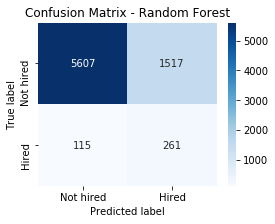

In [41]:
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues" ,fmt='g', 
            xticklabels = ['Not hired', 'Hired'], 
            yticklabels = ['Not hired', 'Hired'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest");

* The average accuracy using 5-Fold cross-validation is 0.779 (78%), with standard deviation of 0.0085. This is very similar to the accuracy obtained by the test set (0.78).

* Precision is very high (0.98) for the class were freelancers are not hired. However, for taskers that are hired, the precision is extremely low with a value of 0.15. This translates into a low f1 score of 0.24 for the hired class.

### Feature selection using umbalanced data

                     Random-Forest
category_1                0.005776
category_2                0.006580
category_3                0.006626
hourly_rate               0.076546
num_completed_tasks       0.189013
position                  0.715460


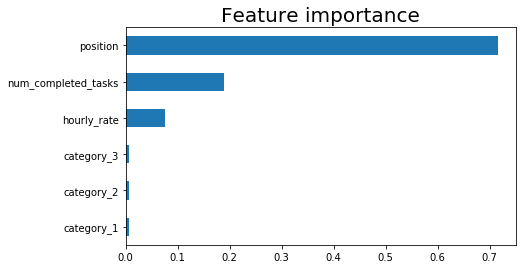

In [42]:
# Feature selection using umbalanced data
#RandomForest
impor_Forest = Ran.feature_importances_
#indices = np.argsort(importances)[::-1]
indices_1 = np.argsort(impor_Forest)[::-1]
featimp_1 = pd.Series(impor_Forest, index=X_train.columns).sort_values(ascending=False)

Table_impor = pd.DataFrame({'Random-Forest': featimp_1}).sort_values('Random-Forest',
                                                                     ascending=True)
print(Table_impor)

Table_impor.plot(kind='barh', figsize = (7, 4), legend=None)
plt.title('Feature importance', size=20);

### Results using umbalanced dataset:
* The most important factors that impact a client's choice to select a freelancer are: position, number of completed tasks, and hourly rate.

* Due to the fact that the target variable is umbalanced, the algorithm does not have enough records to train the model for the case when a freelancer is hired (hired = 1), resulting in a low precision for these cases (0.15 - high number of false positives).

* A low precision (positive class) means that the model will have a high number of false positives (FP), i.e., freelancers that are not booked but the model predicts as hired. 

* On the other hand, having a low recall means that the number of false negative (FN) would be high, i.e., freelancers that are booked are predicted as not hired.

* Because both scenarios are not favorable for our use case, a good metric is the f1-score (harmonic mean of precision and recall).

## Balancing the data and Random Forest Classifier 

In order to increase the precision of this model, both target classes need to be balanced, so the algorithm has enough example from hired and not hired to train the model. In order to balance the dataset the minority class was up-sampled.

The steps for up-sampling are:

1. Separate observations from each class into different DataFrames.
2. Resample the minority class with replacement, setting the number of samples to match the majority class.
3. Combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [43]:
# Creating a dataframe with features and target
df_enc = pd.concat([X_train, y_train], axis=1)
df_enc.shape

(22500, 7)

In [44]:
df_enc.head()

,category_1,category_2,category_3,position,hourly_rate,num_completed_tasks,hired
12880,1.0,0.0,0.0,6.0,46.0,338.0,0
14868,1.0,0.0,0.0,15.0,29.0,0.0,0
14280,0.0,0.0,1.0,8.0,26.0,68.0,0
5318,0.0,0.0,1.0,12.0,70.0,11.0,0
15421,1.0,0.0,0.0,3.0,40.0,0.0,0


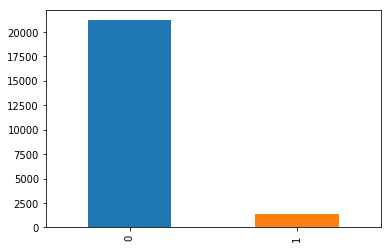

In [45]:
# checking the amount of hired and nom-hired cases
df_enc.hired.value_counts().plot(kind='bar');

In [46]:
# separate minority and majority classes
not_hired = df_enc[df_enc.hired == 0]
hired = df_enc[df_enc.hired == 1]

# upsample minority
hired_upsampled = resample(hired,
                          replace=True,             # sample with replacement
                          n_samples=len(not_hired), # match number in majority class
                          random_state=0)           # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_hired, hired_upsampled])

In [47]:
upsampled.shape

(42342, 7)

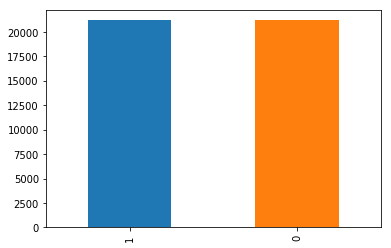

In [48]:
upsampled.hired.value_counts().plot(kind='bar');

In [49]:
X_upsampled = upsampled[columns]
X_upsampled.shape

(42342, 6)

In [50]:
y_upsampled = upsampled.hired
y_upsampled.shape

(42342,)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, 
                                                    test_size=0.25, 
                                                    random_state=0)

In [52]:
print(X_train.shape) 
print(y_train.shape);

(31756, 6)
(31756,)


In [53]:
# Create the random grid
param_dist = {'n_estimators': [50,100,150,200,250],
               "max_features": [1,2,3,4,5,6],
               'max_depth': [1,2,3,4,5,6,7,8],
               "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier()

rf_cv = RandomizedSearchCV(rf, param_distributions = param_dist, 
                           cv = 5, random_state=0, n_jobs = -1)

rf_cv.fit(X_train, y_train)

print("Tuned Random Forest Parameters: %s" % (rf_cv.best_params_))

Tuned Random Forest Parameters: {'n_estimators': 250, 'max_features': 2, 'max_depth': 7, 'criterion': 'entropy'}


Accuracy: 0.7575099187606272

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5291
           1       0.77      0.74      0.75      5295

   micro avg       0.76      0.76      0.76     10586
   macro avg       0.76      0.76      0.76     10586
weighted avg       0.76      0.76      0.76     10586


Average 5-Fold CV Score: 0.7616 , Standard deviation: 0.0051


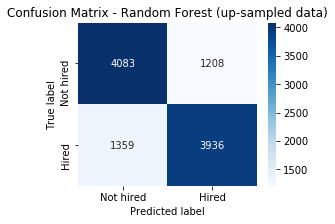

In [54]:
Ran = RandomForestClassifier(criterion= 'entropy', max_depth= 7, 
                                     max_features= 2, n_estimators= 250,
                                     random_state=0)
Ran.fit(X_train, y_train)
y_pred = Ran.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(Ran, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,Ran.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues" ,fmt='g', 
            xticklabels = ['Not hired', 'Hired'], 
            yticklabels = ['Not hired', 'Hired'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Random Forest (up-sampled data)");

* By upsampling the data, the f1-score of the 'hired' class increased from 0.24 to 0.75. This result was expected since the algorithm had more samples to be trained and thus, it is able to better generalize and make predictions using unseen data.

### Receiver Operating Characteristic (ROC)
The performance of the binary classifier is visualized using the ROC graph. For all possible threshold of probabilities, the false positive and true positive rates are calculated.

### Area Under the Curve (AUC)
It measures performance across all classification thresholds. An AUC of 1 means the model can perfectly separate classes. An AUC of 0.5 means the model has no separation power and it is equivalent to a random chance.

Below, there is an schema showing the distributions of probabilities of a model and its corresponding ROC curve.

![][Distribution of Probabilities]

[Distribution of Probabilities]:https://miro.medium.com/max/507/1*yF8hvKR9eNfqqej2JnVKzg.png "Distribution of Probabilities"

![][ROC]

[ROC]:https://miro.medium.com/max/365/1*-tPXUvvNIZDbqXP0qqYNuQ.png "ROC"

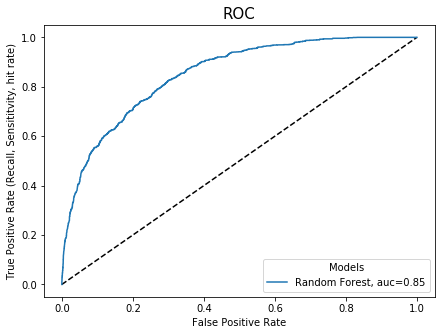

In [55]:
# ROC
y_pred_proba_RF = Ran.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba_RF)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba_RF)

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1,tpr1,label="Random Forest, auc="+str(round(auc1,2)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall, Sensititvity, hit rate)')
plt.title('ROC', size=15)
#plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

* The AUC obtained for this model is 0.85, which means that there is 85% chance that the model will be able to classify correctly hired from non hired freelancers.

### Feature importance using balanced dataset

                     Random-Forest
category_2                0.005222
category_1                0.007576
category_3                0.008115
hourly_rate               0.145990
num_completed_tasks       0.205420
position                  0.627676


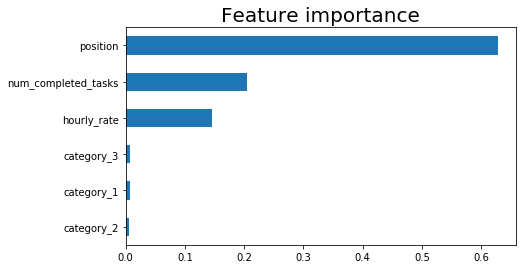

In [56]:
# Feature selection using umbalanced data
#RandomForest
impor_Forest = Ran.feature_importances_
#indices = np.argsort(importances)[::-1]
indices_1 = np.argsort(impor_Forest)[::-1]
featimp_1 = pd.Series(impor_Forest, index=X_train.columns).sort_values(ascending=False)

Table_impor = pd.DataFrame({'Random-Forest': featimp_1}).sort_values('Random-Forest',
                                                                     ascending=True)
print(Table_impor)

Table_impor.plot(kind='barh', figsize = (7, 4), legend=None)
plt.title('Feature importance', size=20);

## Conclusions

The factors that impact the most a client choice to select a freelancer are:
> POSITION (the most importat one) <br>
> NUMBER COMPLETED TASKS <br>
> HOURLY RATE <br>
 
- Feature importance is the same for the models built with umbalanced and balanced data, which indicates that the feature importance obtained by this model is robust.<br>
- By balancing the classes of the data set, the precision of the positive class was increased from 0.15 to 0.77, at the same time the model mantains a good recall of about 0.76.<br>
- Accuracy obtained by the test set and using 5-foldcross-validation are around the same value, 0.76.